# Question 1: Propensity Score Matching

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.linear_model import LogisticRegression

import networkx as nx
from networkx.algorithms import bipartite
from IPython.display import display

%matplotlib inline

In [2]:
data = pd.read_csv('Homework4-data/lalonde.csv', dtype={
    'treat': np.bool_,
    'age': np.uint8,
    'age': np.uint8,
    'nodegree': np.bool_,
    'married': np.bool_,
    'black': np.bool_,
    'hispan': np.bool_,
    're74': np.float32,
    're75': np.float32,
    're78': np.float32
})

In [3]:
display(data.head())

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886


## 1 - A naive analysis

In [4]:
def print_revenues_description(data):
    treated = data.re78[data.treat == True]
    not_treated = data.re78[data.treat == False]   
    print("Treated revenues in 1978:\n", treated.describe())
    print("\nNot treated revenues in 1978:\n", not_treated.describe())

In [5]:
print_revenues_description(data)

Treated revenues in 1978:
 count      185.000000
mean      6349.145508
std       7867.402344
min          0.000000
25%        485.229797
50%       4232.309082
75%       9642.999023
max      60307.929688
Name: re78, dtype: float64

Not treated revenues in 1978:
 count      429.000000
mean      6984.169434
std       7294.164551
min          0.000000
25%        220.181305
50%       4975.504883
75%      11688.820312
max      25564.669922
Name: re78, dtype: float64


In [6]:
def empirical_distribution(data):
    """Computes the empirical distribution of the provided pandas series"""
    return data.value_counts().sort_index().cumsum() / len(data)

We display the earnings in 1978 using boxplots. Remark that to compare and draw conclusions, it is important to use the same scale for the two data series (`sharey='row'` and `sharex='row'`)

We define functions to print the earning because they will be re-used later in the analysis

In [7]:
def print_box_1978_earnings(treated, not_treated):
    """This function will print the 1978 earnings depending on the """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                                   sharey='row', sharex='row',
                                   figsize=(10, 5))

    treated.plot.box(ax=ax1)
    not_treated.plot.box(ax=ax2)
    ax1.set_title('Trained')
    ax2.set_title('Not trained')
    ax1.set_ylabel('Earnings in 1978').set_size(15)

In [8]:
def print_ccdf_1978_earnings(treated, not_treated):
    """This function will print the 1978 earnings from a treated and not treated dataset"""
    fig, ax = plt.subplots(figsize=(10,5))
    (1 - empirical_distribution(treated)).plot(ax=ax, logx=True, logy=True)
    (1 - empirical_distribution(not_treated)).plot(ax=ax)
    ax.legend(['treated', 'not treated'], fontsize=15)
    ax.set_xlabel('Income')
    ax.set_ylabel('CCDF')
    ax.set_title('CCDF of earnings of trained and not trained individuals (loglog)').set_size(18)

In [9]:
def print_1978_earnings(data):
    """ This function print the box and ccdf of the 1978 earnings"""
    treated = data.re78[data.treat == True]
    not_treated = data.re78[data.treat == False]   
    print_box_1978_earnings(treated, not_treated)
    print_ccdf_1978_earnings(treated,not_treated)

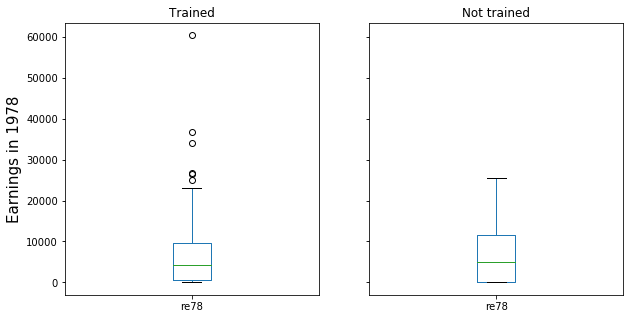

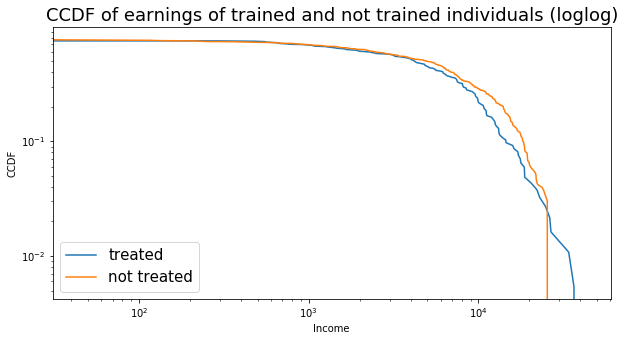

In [10]:
print_1978_earnings(data)

A naive researcher may conclude that, except for some outliers, the training does not make a difference in determining the earnings of the cadidates

## 2 - A closer look at the data

For each feature, we compare its distribution in the control and in the treated group.

In [11]:
def get_feature(feature_name, data):
    """Returns the series corresponding to feature name.
    The returned element is a tuple of two elements, the first
    corresponding to the (treated, not_treated) group"""
    get_treated = lambda treated: data[feature_name][data.treat == treated]
    return get_treated(True), get_treated(False)

We also define functions to help in printing information about the graphs

In [12]:
def print_ccdf(feature, label):
    """Print the ccdf graph from a particular feature. Use the label as the xlabel and in the title""" 
    for cdf in map(empirical_distribution, feature):
        (1 - cdf).plot()
    plt.legend(['treated', 'control'], fontsize=15)
    plt.title('CCDF of {}'.format(label))
    plt.xlabel(label)
    plt.ylabel('CCDF')
    plt.show()

In [13]:
def print_box_plot(feature, label):
    """Print a box plot of the feature. Use the lable to set the title"""
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row')
    for ax, feature in zip(axes, feature):
        feature.plot.box(ax=ax)
    axes[0].set_title('{} of treated'.format(label.capitalize()))
    axes[1].set_title('{} of control group'.format(label.capitalize()))
    plt.show() 

In [14]:
# This array contains functions to print the analysis by property
print_analysis_properties_fcts = []

### Age

In [15]:
def print_age_info(data):
    """Function to print the age information from the specified dataframe"""
    age_groups = get_feature('age', data)
    
    # CCDF plot
    print_ccdf(age_groups, 'age')
    
    # Box plot
    print_box_plot(age_groups, 'age')
    
print_analysis_properties_fcts.append(print_age_info)

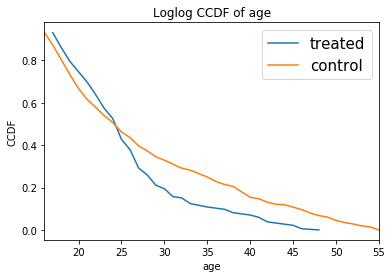

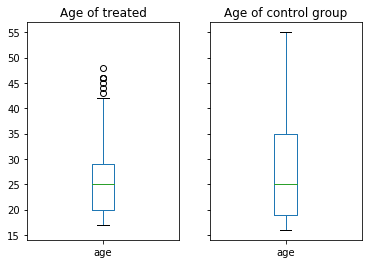

In [16]:
print_age_info(data)

We can see that the members of the treated group are in general younger than the members of the control group.
The medians are very similar, but on the upper part of the distribution, the person in the treated group are younger than the one in the control group.
This leads to think that older people had a low chance to be treated and it might reduce bias in our control group if we removed them after a certain age.

### Education years

In [17]:
def print_ed_info(data):
    ed = get_feature('educ', data)
    
    # CCDF plot
    print_ccdf(ed, 'education years')
    
    # Box plot
    print_box_plot(ed, 'education years')
print_analysis_properties_fcts.append(print_ed_info)

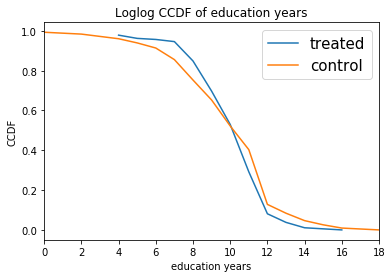

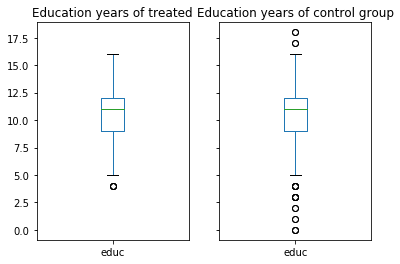

In [18]:
print_ed_info(data)

While the distributions of the variable in the two groups seem similar, the boxplot reveals an interesting detail: the control group has many outliers who studied for less than the 1/4 quantile. There's also some outliers in the maximum education years in the control group.

This might be caused by the fact that people who never studied or studied a lot tended to not get the treatment. Because of this, they might be poor subjects to add in our control group.

### Ethnicity

In [19]:
any(map(lambda tup: all(tup), data[data.hispan == data.black][['black', 'hispan']].values))

False

After having checked that there is no individual marked as both hispanic and black, we can plot the proportion of ethinicity in the the two populations:

In [20]:
def print_ethnicities_info(data):
    ethnicities = ['hispan', 'black']
    fig, axes = plt.subplots(nrows=1, ncols=2)

    for ax, treated in zip(axes, (True, False)):
        # Extract hispanic and black boolean indicators
        eths = data[data.treat == treated][ethnicities]
        # If neither black nor hispanic, add a True to indicate other category
        eths['other'] = reduce(lambda x, y: x & y, map(lambda e: ~eths[e], ethnicities)) # <3 mapreduce
        # Sum to obtain ethnic count
        eths = eths.sum(axis=0)
        # Plot
        ax.axis('equal')
        ax.set_title('Treat' if treated else 'Control')
        ax.pie(eths.values, labels=eths.index, autopct='%1.1f%%')
print_analysis_properties_fcts.append(print_ethnicities_info)

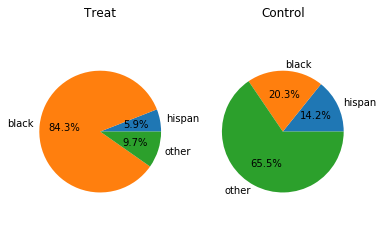

In [21]:
print_ethnicities_info(data)

This reveals an interesting fact: the control and treated populations have very different compositions. While most of the control individuals are neither black nor hispanic (can we assume white?), most of the treated population is black.

### Civil status

In [22]:
def print_civil_status_info(data):
    groups = get_feature('married', data)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    for ax, g in zip(axes, groups):
        c = g.value_counts()
        ax.axis('equal')
        ax.pie(c.values, labels=['married' if t else 'not married' for t in c.index], autopct='%1.1f%%')

    axes[0].set_title('Treat')
    axes[1].set_title('Control')
    plt.show()
print_analysis_properties_fcts.append(print_civil_status_info)

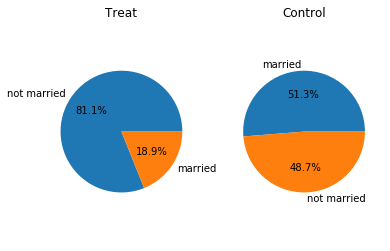

In [23]:
print_civil_status_info(data)

These piecharts highlight another important difference in population composition: most of the treated individuals are not married while almost half of the control population is married.

### Degree

In [24]:
def print_degree_info(data):
    groups = get_feature('nodegree', data)

    fig, axes = plt.subplots(nrows=1, ncols=2)

    for ax, g in zip(axes, groups):
        c = g.value_counts()
        ax.axis('equal')
        ax.pie(c.values, labels=['does not have degree' if t else 'has degree' for t in c.index],
               autopct='%1.1f%%')

    axes[0].set_title('Treat')
    axes[1].set_title('Control')
    plt.show()
print_analysis_properties_fcts.append(print_degree_info)

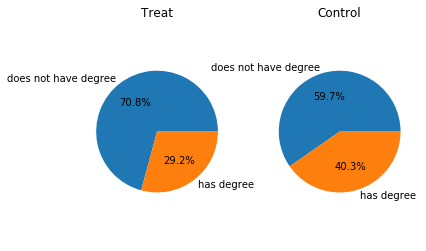

In [25]:
print_degree_info(data)

Yet another important difference: slightly more treated individuals than controlled ones have a degree, which might directly influence their earnings

### Pre-treatment earnings

In [26]:
def print_pre_treatment_earnings(data):
    features = ['re74', 're75']
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='row', figsize=(12, 12))

    for cell, year in zip(axes[0], features):
        for treated in (True, False):
            earnings = data[data.treat == treated][features]
            cell.plot(1 - empirical_distribution(earnings[year]))
            cell.set_xlabel('x (log)')
            cell.set_ylabel('P(earn > x) (log)')
        cell.legend(['treated', 'not treated'])
        cell.set_title(year + ' distribution')           

    for cell, year in zip(axes[1], features):
        cell.boxplot([data[year][data.treat == treated].values for treated in (True, False)])
        cell.set_xticklabels(['treated', 'not treated'])
        cell.set_title(year + ' comparison')
        
    plt.show()
print_analysis_properties_fcts.append(print_pre_treatment_earnings)

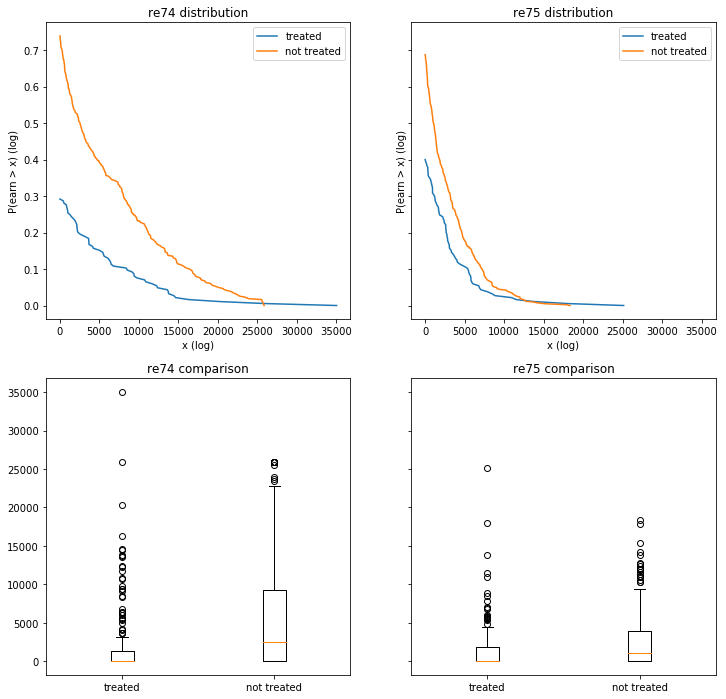

In [27]:
print_pre_treatment_earnings(data)

We observe that the control population had higher earnings than the treated population before the the treatment.

In fact, most of the treated population had no income before the treatment, which might show a bias in treatment towards individuals with no income.

Also, the not treated population had a major reduction in their income distribution after only 1 year.
It implies that many people considered for the not treated population already had work experience prior to the test, but lost their job recently.
This might create a bias in the not treated population, because it is likely that someone with previous work experience has better odds of finding a job than someone with no work experience or long term previous unemployment.

## 3 - A propensity score model

In [28]:
data.dtypes

id           object
treat          bool
age           uint8
educ          int64
black          bool
hispan         bool
married        bool
nodegree       bool
re74        float32
re75        float32
re78        float32
dtype: object

In [29]:
boolean_features = ['treat', 'black', 'hispan', 'married', 'nodegree']

no_id = data.loc[:, data.columns != 'id']
no_id = no_id.loc[:, no_id.columns != 're78'].copy() # Based on pre-treatment features => exclude post treatment features

for feat in boolean_features:
    no_id.loc[:, feat] = no_id[feat].astype(np.uint8)

In [30]:
print('Features used for propensity score computation:')
[col for col in no_id.columns]

Features used for propensity score computation:


['treat',
 'age',
 'educ',
 'black',
 'hispan',
 'married',
 'nodegree',
 're74',
 're75']

In [31]:
x_train = no_id.loc[:, no_id.columns != 'treat'].as_matrix()
y_train = no_id.loc[:, 'treat'].as_matrix()

In [32]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
predictions = lr.predict_proba(x_train)

In [33]:
predictions.shape, np.all(np.sum(predictions, axis=1))

((614, 2), True)

`predict_proba` returns a bidimensional array which has as many rows as data points and as many columns as classification classes. We are interested in the propensity score which is the probability of receiving the treatment. Therefore we want the second column of `predictions`

In [34]:
# Rebuild indexed series
propensities = pd.Series(predictions[:, 1], index=no_id.index)
propensities.name = "propensity"
display(propensities.head())

0    0.443350
1    0.144660
2    0.722355
3    0.664151
4    0.698286
Name: propensity, dtype: float64

To have simple access, we will merge the propensity scores with the data DataFrame.

In [35]:
data_prop = pd.concat([data, propensities], axis=1) 
display(data_prop.head(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898,0.443350
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043,0.144660
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219,0.722355
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996,0.664151
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886,0.698286


## 4 - Balancing the dataset via matching

We now want to balance the dataset by using the propensity score we calculated. The goal is to match each treated subject with a not treated subject that has a similar propensity score. 

To do so, we will realize a bipartite graph using the networkx library.

### Create a matched dataset

In [36]:
# Create sub dataframes that will be used to realize the matching
treated_prop = data_prop[data_prop['treat'] == True]
not_treated_prop = data_prop[data_prop['treat'] == False]

In [37]:
def create_matched_bipartite_graph(treated, not_treated, forced_match=[] , max_age_diff=5):
    """ Create a matched bipartite graph from two subgraphs
        Preferential matches can be created by adding in the forced match arrays values from:
            ['ethnicity', 'age', 'degree', 'married']
        If 'age' is set, max_age_diff will be used to determine the maximum allowed age difference between nodes
        
        Note: this function has more complexity than needed for this section, but it will be used in
              the following sections
    """
    # Create a bipartite graph with all nodes
    bip_graph = nx.Graph(name="all_edges_bip")
    bip_graph.add_nodes_from(treated_prop.index.values, bipartite=0)
    bip_graph.add_nodes_from(not_treated_prop.index.values, bipartite=1)

    matched_bip_graph = bip_graph.copy()
    matched_bip_graph.name = "matched_bip"

    
    def valid_match(treated, not_treated):
        """Local function to create the forced comparison between the selected match"""
        compare_ethnicity = lambda treated, not_treated: treated.black == not_treated.black and \
                                                         treated.hispan == not_treated.hispan
        compare_age = lambda treated, not_treated: abs(int(treated.age)-int(not_treated.age)) <= max_age_diff
        compare_degree = lambda treated, not_treated: treated.nodegree == not_treated.nodegree
        compare_married = lambda treated, not_treated: treated.married == not_treated.married
        
        good_ethnicity = compare_ethnicity(treated, not_treated) if 'ethnicity' in forced_match else True
        good_age = compare_age(treated, not_treated) if 'age' in forced_match else True
        good_degree = compare_degree(treated, not_treated) if 'degree' in forced_match else True
        good_married = compare_married(treated, not_treated) if 'married' in forced_match else True
        return good_ethnicity and good_age and good_degree and good_married
    
    for treated in treated_prop.itertuples():
        for not_treated in not_treated_prop.itertuples():
            # Only add edge if we have a match
            if valid_match(treated, not_treated):
                # We the propensity is from 0 to 1, therefore  0 <= abs(diff(prop)) <= 1
                # We substract the absolute difference from 1 to obtain greater score for better match
                # This allows using a maximum matching algorithm
                propensity_val =  1-abs(treated.propensity-not_treated.propensity)
                bip_graph.add_edge(treated.Index, not_treated.Index, weight=propensity_val)

    # Validate the graph properties
    print("Initial Graph properties")
    print(nx.info(bip_graph))
    print("Bipartite: {}".format(nx.is_bipartite(bip_graph)))

    matched_bip_dict = nx.max_weight_matching(bip_graph, maxcardinality=True)
    matched_bip_graph.add_edges_from(matched_bip_dict.items())
    # Remove isolated nodes
    matched_bip_graph.remove_nodes_from(nx.isolates(matched_bip_graph))
    print("\nMatched Graph properties")
    print(nx.info(matched_bip_graph))
    print("Bipartite: {}".format(nx.is_bipartite(matched_bip_graph)))
    return matched_bip_graph

In [38]:
matched_bip_graph = create_matched_bipartite_graph(treated_prop, not_treated_prop)

Initial Graph properties
Name: all_edges_bip
Type: Graph
Number of nodes: 614
Number of edges: 79365
Average degree: 258.5179
Bipartite: True

Matched Graph properties
Name: matched_bip
Type: Graph
Number of nodes: 370
Number of edges: 185
Average degree:   1.0000
Bipartite: True


In [39]:
def df_from_bip_graph(matched_bip_graph):
    """Create a dataframe from a matched bipartite graph"""
    node_index_list = matched_bip_graph.nodes()

    return data.loc[node_index_list]

In [40]:
matched_data = df_from_bip_graph(matched_bip_graph)
display(matched_data.head(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043
2,NSW3,True,30,12,True,False,False,False,0.0,0.0,24909.449219
3,NSW4,True,27,11,True,False,False,True,0.0,0.0,7506.145996
4,NSW5,True,33,8,True,False,False,True,0.0,0.0,289.789886


### Income re78

In [41]:
print_revenues_description(matched_data)

Treated revenues in 1978:
 count      185.000000
mean      6349.145508
std       7867.402344
min          0.000000
25%        485.229797
50%       4232.309082
75%       9642.999023
max      60307.929688
Name: re78, dtype: float64

Not treated revenues in 1978:
 count      185.000000
mean      5312.475098
std       5842.885742
min          0.000000
25%          0.000000
50%       3392.860107
75%       7933.914062
max      20243.380859
Name: re78, dtype: float64


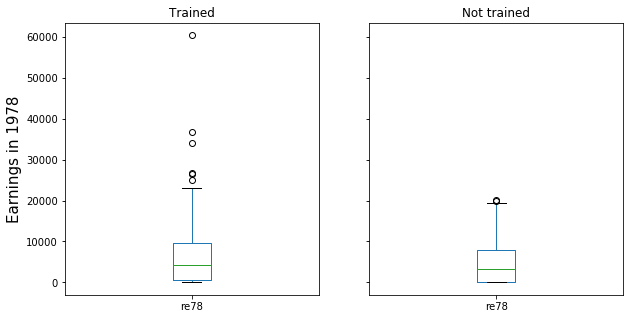

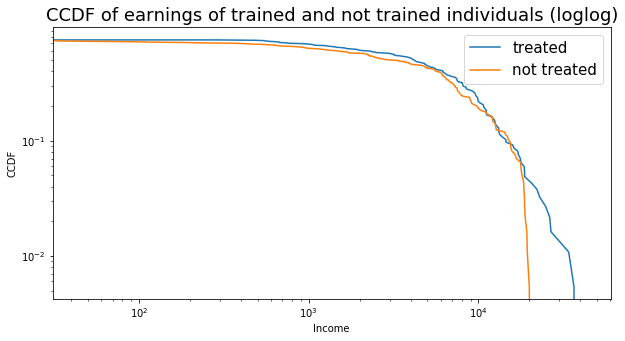

In [42]:
print_1978_earnings(matched_data)

We can see from the matched results that the treated subset had better income in re78.
From this we could conclude that the training helped to raise the salary of the trainee.

### Value distribution comparisons

In [43]:
# Lets check how many analysis function we have
print(len(print_analysis_properties_fcts))

6


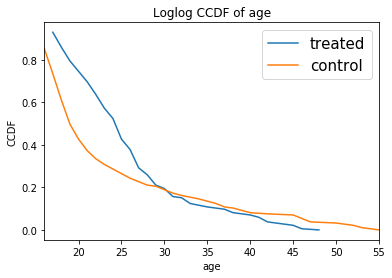

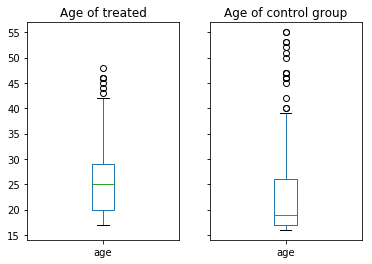

In [44]:
print_analysis_properties_fcts[0](matched_data)

We can see that the age is not evenly distributed in the matched group. There's more very young person ($<20$ years old in the control group. This might be a bias, especially in salary: a 15 years old will likely have a big difference in income with a 25 years old.

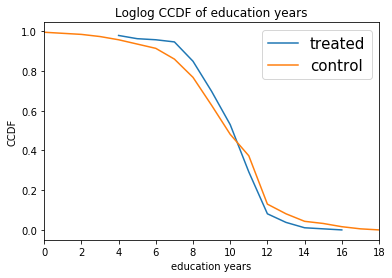

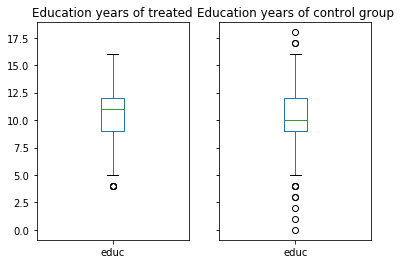

In [45]:
print_analysis_properties_fcts[1](matched_data)

We can see that we have brought the median age down in the control group with our selection.

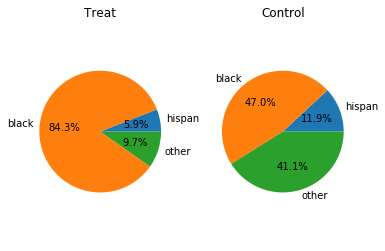

In [46]:
print_analysis_properties_fcts[2](matched_data)

We can see that the proportion of "Black" has increased in the control set.
The discrepancy in the populations are still very high, we need to find some way to force the black population to be matched more evenly.

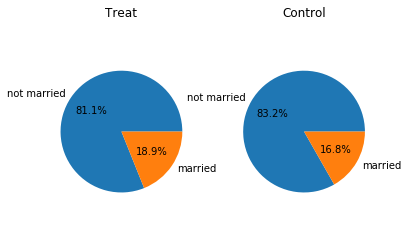

In [47]:
print_analysis_properties_fcts[3](matched_data)

We can see that the married are really close matches compared to the previous results. 


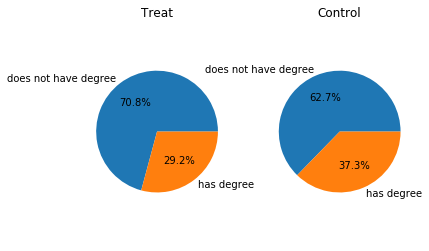

In [48]:
print_analysis_properties_fcts[4](matched_data)

We can see that the degree distribution has decreased by a low amount in the control dataset.

We could attempt to provide a better match for the degree distribution.

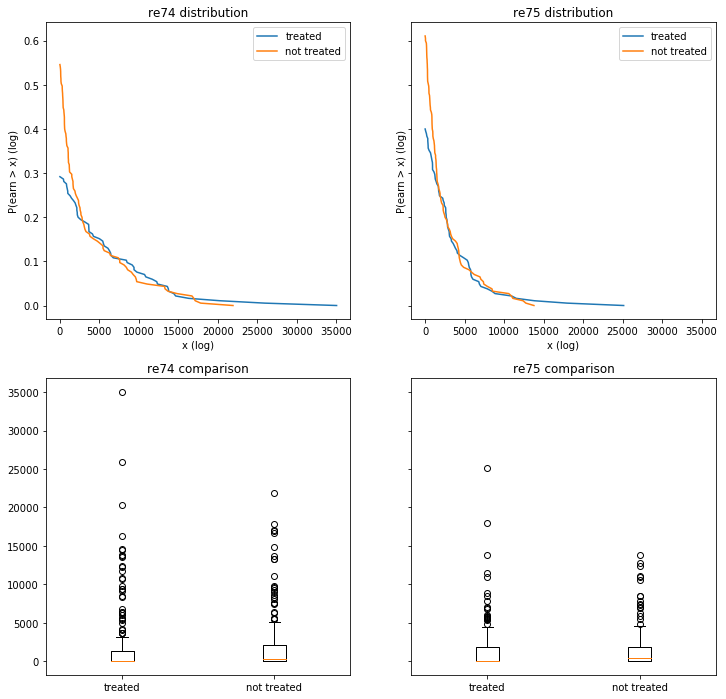

In [49]:
print_analysis_properties_fcts[5](matched_data)

The income match is way closer than previously. 
There's still outliers in the dataset, but we can see that the not treated curve now follows the treated curve more closely.

From this second analysis it seems that the previous income distribution, education years and the marital status are well fitted in the matched graph.

The age, ethnicity and degree parameter would still need to be adjusted to have a better fit.

## Balancing the groups further

In this section, we will attempt to balance the indicators that where not fully satisfying.

Those indicators are the the age, the ethnicity and the degree.

For the age, we will force the matches to be within MAX_AGE_DIFF of each other

For the ethnicity and degree we will force them to be shared between matches.

We will also force the married status, to make sure it is a good match, doing so didn't reduce the graph size, so it is not really costly.

In [50]:
# Make sure that we can actually optimize ethnicity
print("Black treated: {}".format(len(data[data.black & data.treat])))
print("Black not treated: {}".format(len(data[data.black & ~data.treat])))
print("Hispano treated: {}".format(len(data[data.hispan & data.treat])))    
print("Hispano not treated: {}".format(len(data[data.hispan & ~data.treat]))) 

Black treated: 156
Black not treated: 87
Hispano treated: 11
Hispano not treated: 61


From those result, we can see that we will not be able to match every nodes from the treated dataset in the new result, because we will need to drop some "Black treated" if we force the ethnicity to match

### Creating a matched dataset with preferential treatment

In [51]:
pref_matched_bip_graph = create_matched_bipartite_graph(treated_prop, not_treated_prop,
                                                        forced_match=['age', 'ethnicity', 'married', 'degree'],
                                                        max_age_diff=3)

Initial Graph properties
Name: all_edges_bip
Type: Graph
Number of nodes: 614
Number of edges: 2108
Average degree:   6.8664
Bipartite: True

Matched Graph properties
Name: matched_bip
Type: Graph
Number of nodes: 206
Number of edges: 103
Average degree:   1.0000
Bipartite: True


We can see that our fully preferential treatment reduced the size of the dataset by 85 edges.
We also tested by matching the (age, ethnicity), (age, ethnicity, married) and the resulting number of edges was 111.
Because the difference is marginal, we went with a full preferential treatment

In [52]:
pref_matched_data = df_from_bip_graph(pref_matched_bip_graph)
display(pref_matched_data.head(2))
display(pref_matched_data.tail(2))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,True,37,11,True,False,True,True,0.0,0.0,9930.045898
1,NSW2,True,22,9,False,True,False,True,0.0,0.0,3595.894043


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
607,PSID423,False,27,10,True,False,False,True,0.0,0.0,7543.793945
612,PSID428,False,32,5,True,False,True,True,0.0,0.0,187.671295


### Value distribution comparisons

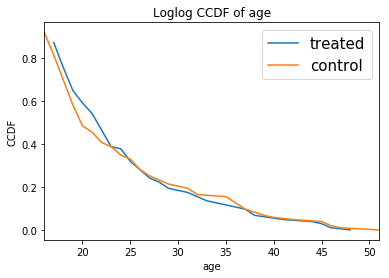

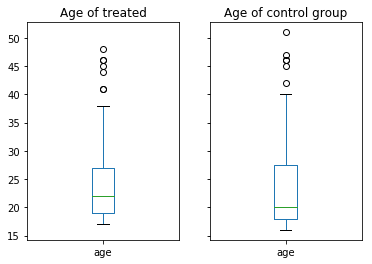

In [53]:
print_analysis_properties_fcts[0](pref_matched_data)

The age graph are way better fits after the preferential matching.
There control median age is still lower than the treated, but to augment it we would lead to less nodes in the match.
We feel that the current value is good enough.

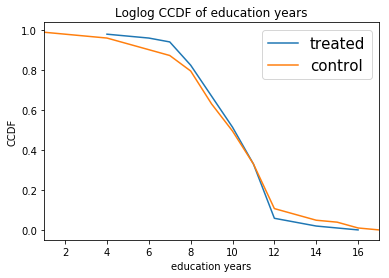

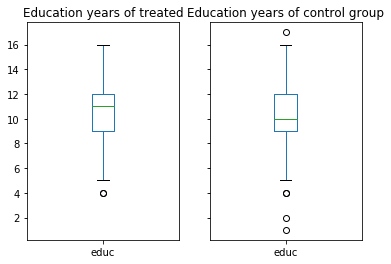

In [54]:
print_analysis_properties_fcts[1](pref_matched_data)

The education year fit are very similar, our new preferential matching didn't affect it too much.

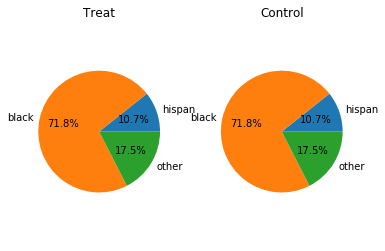

In [55]:
print_analysis_properties_fcts[2](pref_matched_data)

We can see that this is where the preferential matching shines: we have a perfect match for ethnicity in our dataset.


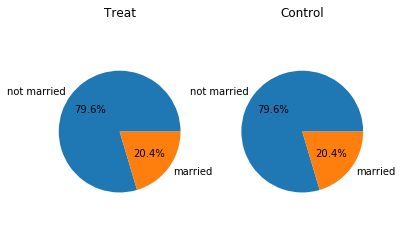

In [56]:
print_analysis_properties_fcts[3](pref_matched_data)

We can see that we also have a perfect match in the married status


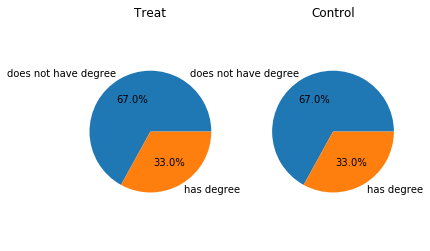

In [57]:
print_analysis_properties_fcts[4](pref_matched_data)

We can see that the degree are also a perfect match now.

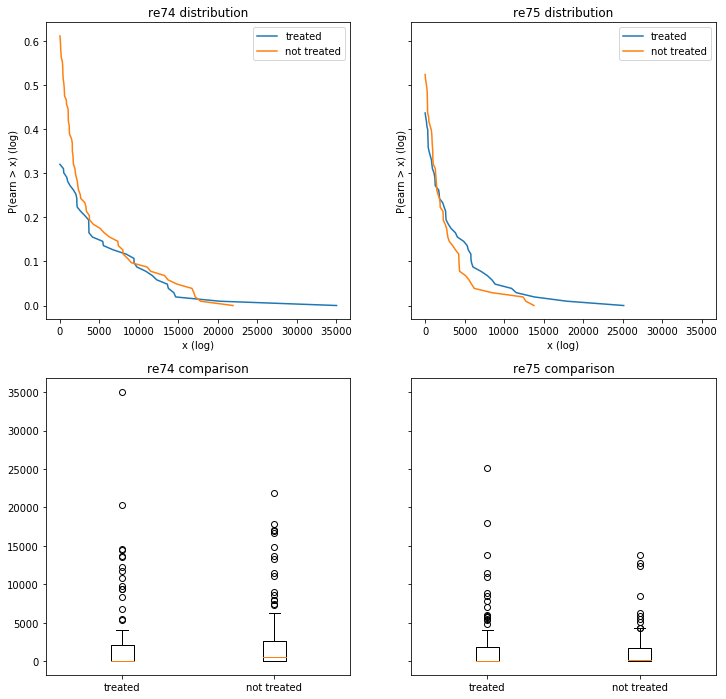

In [58]:
print_analysis_properties_fcts[5](pref_matched_data)

The fit in the pretreatment income is similar to the previous matching.
It looks like the re74 distribution match is worst than the unpreferential match.
Though, the difference is not very substantial and the two graphs where already not a great match, so it is satisfactory.

## A less naive analysis

In [59]:
print_revenues_description(pref_matched_data)

Treated revenues in 1978:
 count      103.000000
mean      6574.360352
std       8386.805664
min          0.000000
25%        800.607849
50%       4814.626953
75%       9833.600098
max      60307.929688
Name: re78, dtype: float64

Not treated revenues in 1978:
 count      103.000000
mean      4926.411621
std       5869.679199
min          0.000000
25%         32.509985
50%       2813.591064
75%       7429.270508
max      23764.800781
Name: re78, dtype: float64


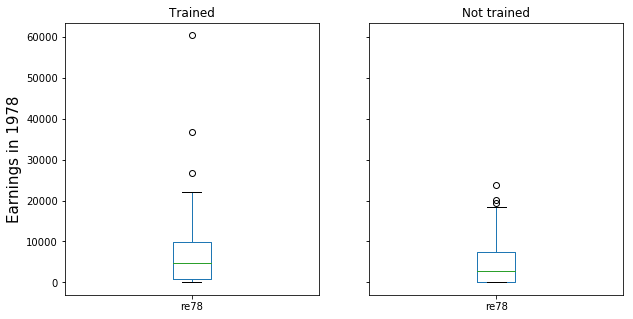

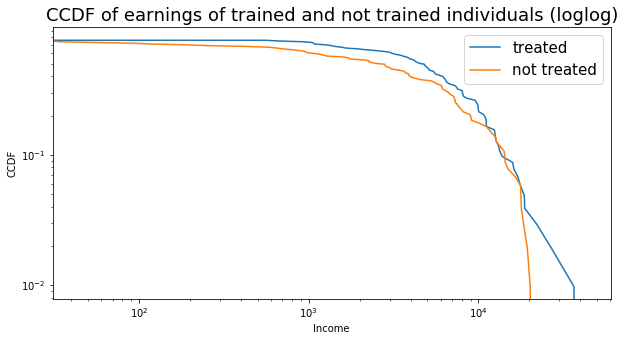

In [60]:
print_1978_earnings(pref_matched_data)

The preferential matching showed a close match between the variables distributions in the resulting dataset.

From this dataset, we can see that the trained individuals are better off than the not trained.

Their average income is 1168$ higher than the not treated group.

Also, every measured quartile has a higher salary in the treated group than in the not treated.

Finally, the maximum income is better in the treated group than in the not treated group.

All the metrics are better for the treated population compared to the not treated population.

# Question 2: Applied Machine Learning

In [61]:
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import json

In [62]:
ENABLE_GRIDSEARCH = False

We first obtain the data and build the TF-IDF document matrix, making sure we exclude english typical stopwords (`the`, `of`, `for`, ...):

In [63]:
data = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_dm = vectorizer.fit_transform(data.data)

In [64]:
tfidf_dm.shape # shape=(num_docs, num_terms)

(18846, 173451)

then we **randomly** split the data in the following way:

 - 10% for validation
 - 10% for testing
 - 80% for training

In [65]:
N = len(data.data)
t_N = int(0.1 * N)

indices = np.random.choice(range(len(data.data)),
                           size=2*t_N,
                           replace=False)

test_ids, valid_ids = indices[:t_N], indices[t_N:]
train_ids = np.setdiff1d(np.arange(N), indices, assume_unique=True)

assert len(train_ids) + len(test_ids) + len(valid_ids) == N

x_train, y_train = tfidf_dm[train_ids], data.target[train_ids]
x_val,   y_val   = tfidf_dm[valid_ids], data.target[valid_ids]
x_test,  y_test  = tfidf_dm[test_ids],  data.target[test_ids]

The grid search is performed in a two dimensional space: one dimension for the number of estimators and one for the maximal depth of the trees. We stored our result in a file to avoid lengthy computations at each run.

In [66]:
if ENABLE_GRIDSEARCH:
    # grid search n_estimators and max_depth 
    validate = lambda n, d: RandomForestClassifier(n_estimators=n, max_depth=d).fit(x_train, y_train)\
                                                                               .score(x_val, y_val)
    accuracies = []
    for n in range(40, 60):
        # run once with no max to get upper bound
        for depth in range(75, 90):
            score = validate(n, depth)
            accuracies.append((n, depth, score))
    
    with open('grid_search.json', 'w') as f:
        json.dump(accuracies, f)
else:
    with open('grid_search.json', 'r') as f:
        accuracies = json.load(f)

In [67]:
accuracies = sorted(accuracies, key=lambda t: t[2])

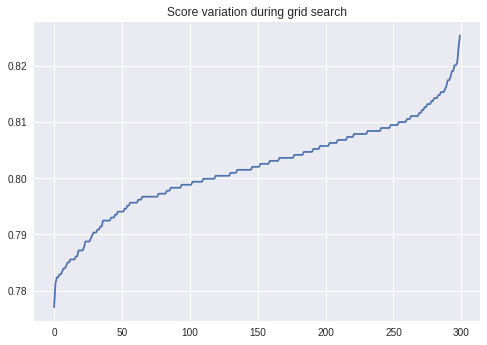

In [78]:
fig, ax = plt.subplots()
_, _, accs = zip(*accuracies)
ax.plot(accs)
ax.set_title('Score variation during grid search')

The best parameters and the associated score are:

In [69]:
accuracies[-1]

[56, 86, 0.8253715498938429]

Now that we have good parameters, we can train and predict

In [70]:
n, d, _ = accuracies[-1]
rfc = RandomForestClassifier(n_estimators=n, max_depth=d)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

We compute the confusion matrix

In [71]:
categories = np.sort(np.unique(data.target))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=predictions, labels=categories)

As this is quite a large matrix, a regular table would hard to display and read at once. Therefore we decided to visualize the confusion matrix as a heatmap.

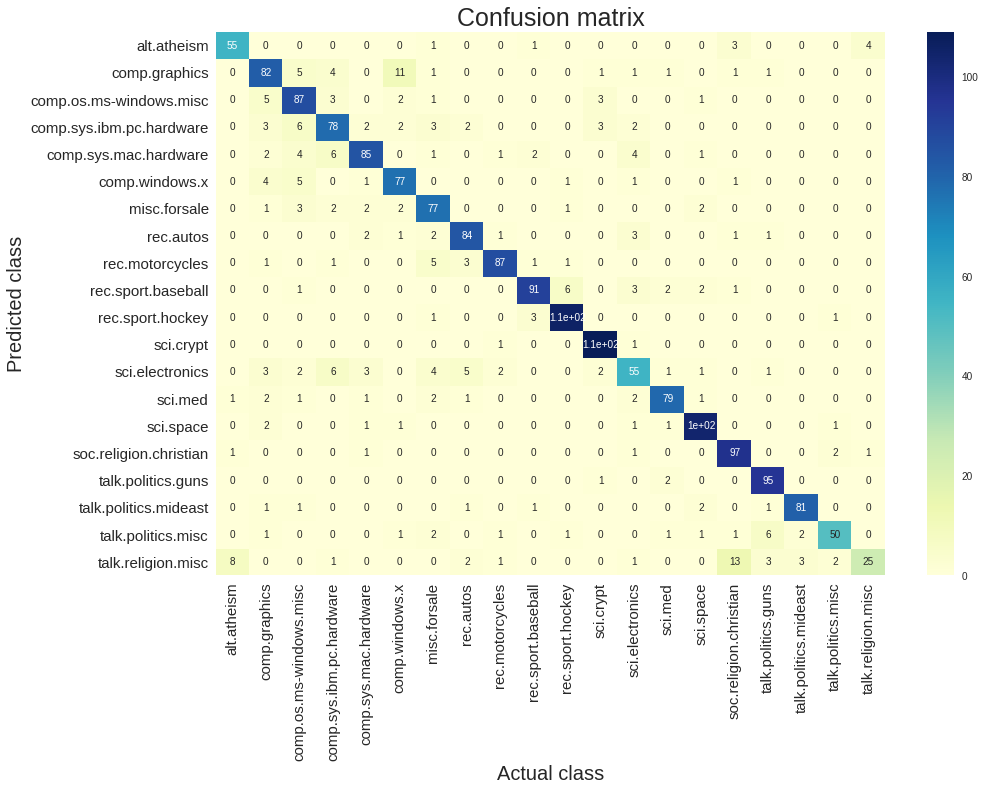

In [72]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(confusion_mat,
            xticklabels=data.target_names,
            yticklabels=data.target_names,
            annot=True,
            cmap='YlGnBu',
            annot_kws={'size': 10},
            ax=ax)

ax.set_ylabel('Predicted class').set_size(20)
ax.set_xlabel('Actual class').set_size(20)

for tick in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    tick.set_size(15)

ax.set_title('Confusion matrix').set_size(25)

In [73]:
idx_to_importance = zip(range(len(rfc.feature_importances_)), rfc.feature_importances_)
indices, importances = zip(*sorted(idx_to_importance, key=lambda t: t[1]))

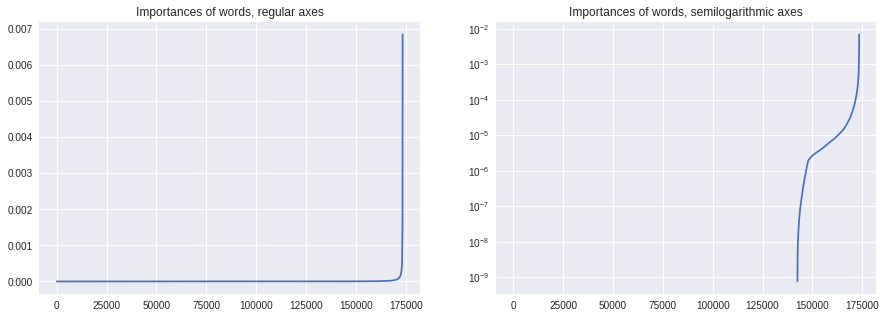

In [74]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.plot(importances)
ax1.set_title('Importances of words, regular axes')
ax2.semilogy(importances)
ax2.set_title('Importances of words, semilogarithmic axes')

we observe that a few features have very high importance. Knowing that each feature is a term, let's see what words are the most important in the classification:

In [75]:
vocabulary = {idx: word for word, idx in vectorizer.vocabulary_.items()}

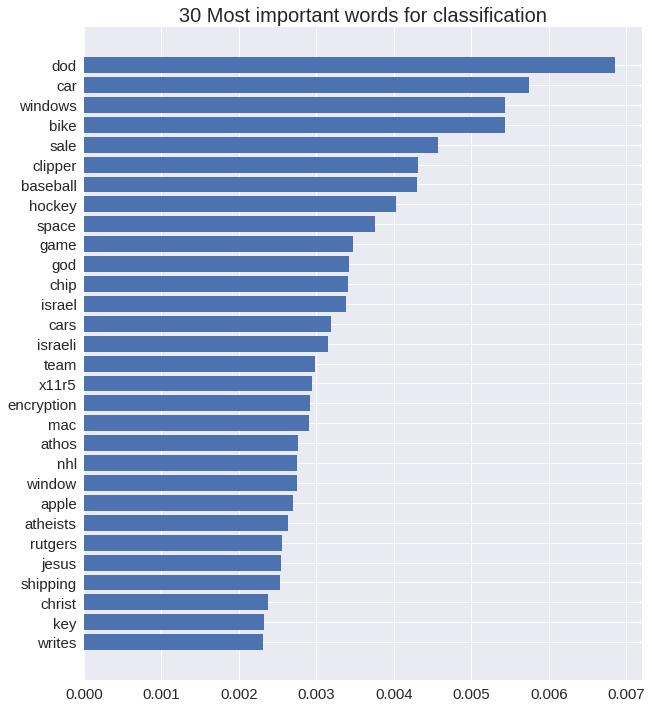

In [76]:
N = 30
words = [vocabulary[idx] for idx in indices[-N:]]

fig, ax = plt.subplots(figsize=(10, 12))

ax.barh(range(N), importances[-N:], tick_label=words)

ax.set_title(str(N) + ' Most important words for classification').set_size(20)

for tick in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
    tick.set_size(15)

From our observation we can conclude that most important keywords seem to already predict and represent a category : a text containing god will more likely be religious. Some of least indicative ones still indicate a topic, they probably only show up in one text but strongly indicate the type of text. We thus have a few very relevant features and less lesser relevant ones